# Code Replication: Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora

In this notebook, we present some of the interesting results we collected from our replication of [Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora](https://arxiv.org/abs/1606.02820).

The paper presents SocialSent, a framework for inducing domain-specific sentiment lexicons. Their approach relies on specifing a small amount of *seed words* to bootstrap their algorithm. The algorithm claims to be competitive with state-of-the-art approachs that usually rely heavily on large, hand crafted feature-sets.

### Code Rewrite and Maintenance

While the original paper does have [https://github.com/williamleif/socialsent/](source code available), we found numerous issues with it. The codebase is written in an outdated Python version (2.7), and depends on old packages, such as Keras 0.3. Among other packages, the Keras package is highly outdated, and currently seems to be uninstallable using `pip`. Furthermore, the repository lacks scripts to acquire and preprocess the data, and is very difficult to use due to the prevalance of hard-coded paths throughout the project. While these issues have been addressed by the authors ([#5](https://github.com/williamleif/socialsent/issues/5) [#12](https://github.com/williamleif/socialsent/issues/12) [#13](https://github.com/williamleif/socialsent/issues/13)), there has not been any work to resolve them.

To be able to run the code, we heavily refractored the original code base and have made it [available online](https://github.com/max-eth/domain-specific-sentiment-lexicons). Our contributions include porting the code to be runnable on current python versions, refractoring the paths and algorithm parameters into an easily configureable location, adding user features such as command line UIs and progress indicators, as well as instructions and scripts to allow users to easily run the algorithm on modern reddit datasets. We also undertook several performance oriented changes due to limitations in our compute resources. Finally, we implemented several new features, which will be detailed later in the notebook.


In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.preprocessing import StandardScaler

import json
from tqdm.notebook import tqdm

import os

import pyximport
pyximport.install(setup_args={"include_dirs": np.get_include()})
from socialsent.representations import sparse_io
from socialsent.main import compute_polarities

unable to import 'smart_open.gcs', disabling that module


In [3]:
plt.style.use('seaborn') # for better looking plots

In [4]:
# Utility methods
def load_df(sub, prefix='stemmed-scores-0-', scale=True, counts=True):
    pols = pickle.load(open("data/{}/{}polarities.pkl".format(sub, prefix), "rb"))
    means = defaultdict(list)
    for run in pols:
        for word, value in run.items():
            means[word].append(value)
        
    df = pd.DataFrame([(word, np.nanmean(values), np.nanstd(values)) for word, values in means.items()], columns =["word", "mean", "std"])

    df = df.sort_values(by=["mean"], ascending=False)
    
    if counts:
        get_top5_coocs(df, sub, prefix)
        
    if scale:
        scaler = StandardScaler(with_std=False)
        df["mean"] = scaler.fit_transform(df["mean"].values.reshape(-1, 1))
    df = df[df["word"].apply(lambda x: len(x)) > 1] 

    return df.set_index('word')
    
def get_top5_coocs(df, subreddit, prefix):
    mat = sparse_io.retrieve_mat_as_coo("data/{}/{}counts.bin".format(subreddit, prefix).encode()).tocsr()
    index = pickle.load(open('data/{}/{}index.pkl'.format(subreddit, prefix), 'rb'))

    arr = np.array(mat.todense())

    rev_index = {v: k for k, v in index.items()}

    # remove words that we don't need counts for
    pol_idx = np.array([
        index[word] for word in df['word']
    ])
    arr = arr[pol_idx, :]

    # remove stopwords
    stopword_idx = np.array([index[stopword] for stopword in STOPWORDS if stopword in index])
    arr[:, stopword_idx] = 0

    top_idx = np.argsort(arr, axis=1)[:, -5:]

    top_words = [list(map(lambda x: rev_index[x], row)) for row in top_idx]
    df['cooccurring_words'] = top_words

def compare(subA, subB, prefixA='stemmed-scores-0-', prefixB='stemmed-scores-0-', scale=True):
    
    df_A = load_df(subA, prefixA, scale=scale).reset_index()
    df_B = load_df(subB, prefixB, scale=scale).reset_index()
    
    joined = df_A.merge(df_B, on='word', how="inner", suffixes=("_" + subA, "_" + subB))
    
    joined["mean_difference"] = joined["mean_" + subA].values - joined["mean_" + subB].values
    joined["std_difference"] = np.sqrt(joined["std_" + subA].values**2 + joined["std_" + subB].values**2)

    joined = joined.sort_values(by=["mean_difference"], ascending=False)
    return df_A.set_index('word'), df_B.set_index('word'), joined.set_index('word')

# Dataset
The original paper showcased results of SentProp on a dataset of reddit comments from 2015, collected from the 250 most popular subreddits. We decided to analyze a new, different dataset; we collected posts from 2019, spanning the months of July, August and September. Instructions showing how to run the code on this dataset can be found in the README of our repository.

Over the years, the nature of reddit appears to have shifted heavily in size: popular subreddits (sub-forums of reddit dedicated to specific topics), such as r/AskReddit have grown from ~10M to ~30M subscribers. 

Due to limitations of our compute resources, we focus on a smaller timespan of 3 months, and a smaller selection of hand-picked subreddits that we found interesting. 

# Sentiment Lexicon Generation
With SentProp, sentiment scores can be generated for a corporus. Given some seed words, sentiment scores are obtained by building a graph from corpus specific word embeddings, and propagating sentiment values across this graph.

Unless indicated otherwise, we use the same seed words as the paper:

In [5]:
from socialsent.seeds import twitter_seeds
print("Positive:", twitter_seeds()[0])
print("Negative:", twitter_seeds()[1])

Positive: ['love', 'loved', 'loves', 'awesome', 'nice', 'amazing', 'best', 'fantastic', 'correct', 'happy']
Negative: ['hate', 'hated', 'hates', 'terrible', 'nasty', 'awful', 'worst', 'horrible', 'wrong', 'sad']


Our first results show a small sample of sentiment values we generate for the subreddit r/sports, which is dedicated to coverage and discussion of professional sport events.

The following cell shows the top sentiment values we generated. Following the approach from the paper, we perform variance estimation by running the propagation several times with different subsets of the seed words. In the following table, **mean** represents the mean sentiment values across the runs, **std** represents the standard deviation, and **coocurring_words** lists the 5 most common words that appeared within a sliding window of the word in the corpus.

In [6]:
load_df("sports", "").head(10)

,mean,std,cooccurring_words
word,,,
catch,0.170501,0.094655,"[time, play, https, away, ball]"
say,0.169856,0.098214,"[let, time, thing, like, people]"
fan,0.161450,0.107344,"[huge, big, team, football, fan]"
class,0.159139,0.109722,"[athletes, class, like, weight, world]"
hope,0.148315,0.089210,"[way, guy, man, gets, like]"
day,0.137612,0.128347,"[test, end, like, day, hours]"
impressive,0.133323,0.093401,"[think, way, isn, pretty, damn]"
tennis,0.130294,0.134247,"[like, players, years, women, player]"
damn,0.126240,0.118791,"[impressive, pretty, like, good, god]"


We immediately notice that the results do not seem to have a very high quality. To investigate this further, we downloaded their corpus lexicon, which is reproduced below.

In [7]:
pd.read_csv("data/sports.tsv", sep='\t', names=['word', 'mean', 'std']).sort_values(by=['mean'], ascending=False).head(10)

,word,mean,std
4570,unbelievable,4.85,1.37
4569,epic,4.81,1.81
4568,phenomenal,4.75,1.37
4567,incredible,4.58,1.92
4566,wow,4.45,2.05
4565,sharing,4.36,2.26
4564,impressive,4.24,2.09
4563,outstanding,4.21,1.58
4562,unreal,4.21,2.16
4561,chill,4.19,1.89


Although it is surprising to see such a difference in results, we hypothesize that this is related to our smaller corpus size. In an attempt to improve the results, we experimented with stemming and preprocessing the words using the following normalization function (taken from the lecture notebooks):

In [8]:
import inspect
from socialsent.reddit import subredditgen
print(inspect.getsource(subredditgen.normalize_text))

def normalize_text(doc, stemming):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist and not w.isdigit()] # remove stopwords
    if stemming:
        stemmed = [stemmer.stem(w) for w in nostop] # stem each word
        return stemmed
    else:
        return nostop



After applying this normalization, we find that we achieve qualitatively much better sentiment scores:

In [9]:
load_df("sports", "stemmed-scores-0-").head(10)

,mean,std,cooccurring_words
word,,,
great,0.219501,0.070504,"[remov, player, game, play, like]"
damn,0.202858,0.074010,"[good, delet, god, remov, like]"
wow,0.193097,0.069897,"[realli, delet, wow, remov, like]"
cool,0.182111,0.085584,"[delet, remov, look, realli, like]"
holi,0.175791,0.068748,"[look, like, remov, fuck, shit]"
japan,0.154302,0.061557,"[game, world, ireland, play, team]"
clip,0.153996,0.059631,"[ball, time, remov, watch, like]"
incred,0.149514,0.063179,"[time, look, sport, remov, like]"
remov,0.149165,0.098191,"[know, look, like, delet, remov]"


We attribute this improvement to a higher "data density" resulting from the reduction in the set of words in the corpus.

# Comparative Analysis between Dissimilar Communities
Next, we perform a comparative investigation of sentiment scores between similar dissimilar communities. The general idea of this analysis is similar to that from the paper: for communities dedicated to very different topics, we look to identify interesting differences in sentiment values.

To illustrate these difference, we plot differences of demeaned sentiment values. These plots allow us to identify words which have a highly different sentiment values across the communities. Futhermore, we report the coocurring words for both subreddits in the comparision to provide context.

In [12]:
def plot_comparative(joined, words):
    subA_name = joined.columns[0][5:]
    subB_name = joined.columns[3][5:]
    plot_df = joined.loc[words].reset_index()
    plot_df = plot_df.sort_values(by=['mean_difference'])

    plt.figure()
    plt.barh(plot_df['word'], plot_df['mean_difference'], xerr=plot_df['std_difference'])
    xlabelstr  = """
    More negative in {}                 More positive in {}\n
    <-                        ->\n
    More positive in {}                 More negative in {}
    """
    plt.xlabel((xlabelstr).format(subA_name, subA_name, subB_name, subB_name), fontsize=16)
    plt.show()
    return plot_df.set_index('word')[['cooccurring_words_' + subA_name, 'cooccurring_words_' + subB_name]]

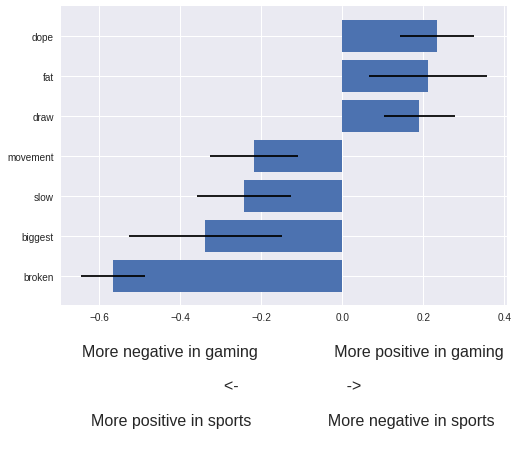

,cooccurring_words_gaming,cooccurring_words_sports
word,,
broken,"[dont, fix, play, like, game]","[year, time, bone, record, like]"
biggest,"[thing, issu, problem, like, game]","[like, year, team, world, sport]"
slow,"[realli, play, like, time, game]","[ball, look, like, speed, motion]"
movement,"[play, use, control, like, game]","[camera, speed, bodi, time, like]"
draw,"[look, line, draw, game, like]","[play, game, peopl, like, line]"
fat,"[play, big, peopl, game, like]","[dont, guy, ass, like, remov]"
dope,"[like, play, pretti, game, look]","[caught, peopl, bolt, athlet, dope]"


In [13]:
df_gaming, df_sports, joined = compare("gaming", "sports")
plot_comparative(joined, ['dope', 'fat', 'draw' ,'broken', 'biggest', 'slow', 'movement'])

In this first comparative plot, we see the effectiveness of the approach in illustrating semantic differences across the communities. Some highlights are:
*  *dope* is used as a positive adjective in r/gaming, while it is associated with performance enhancing drugs in r/sports.
* *broken* seems to refer to a broken or badly produced video game in r/gaming, while it can refer to broken records in r/sports.
* *fat* seems to be a far more positive word in r/gaming than r/sports.

# Comparitive Analysis between Similar Communities
Although the paper did provide some interesting analysis of communities with dissimilar domains, we decided to investigate communities that discuss similar topics.

Of particular interest to us were political subreddits, which have enjoyed large growth in the past few years. In the following analysis, we investigate r/The_Donald and r/politics.

r/The_Donald is a subreddit populated by supporters of Donald Trump. With its current >785,000 subscribers, it is one of the largest and most active political subreddits. Interestingly, the subreddit is rather isolated from the rest of reddit: due to the controversial nature of its users and content, the Reddit administration "quarantined" the subreddit in June 2019, requiring users to "opt-in" to viewing the subreddit and removing it from recommendations and search results.

r/politics is a more general subreddit dedicated to the discussion of mainly US politics.

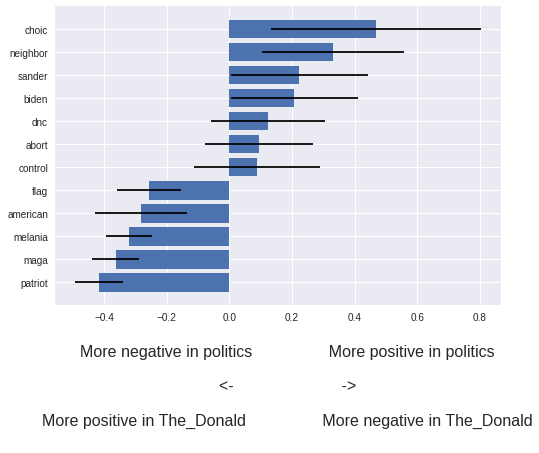

,cooccurring_words_politics,cooccurring_words_The_Donald
word,,
patriot,"[peopl, trump, like, american, act]","[coat, god, love, #, brick]"
maga,"[like, peopl, wear, trump, hat]","[content, wear, trump, #, hat]"
melania,"[think, look, like, remov, trump]","[delet, #, like, look, trump]"
american,"[nativ, like, american, trump, peopl]","[citizen, like, american, peopl, #]"
flag,"[trump, flag, confeder, law, red]","[#, flag, american, law, red]"
control,"[govern, senat, republican, peopl, gun]","[like, #, peopl, control, gun]"
abort,"[gun, like, peopl, abort, right]","[peopl, like, babi, abort, #]"
dnc,"[primari, trump, like, candid, berni]","[remov, trump, candid, like, #]"
biden,"[warren, like, biden, joe, trump]","[like, biden, trump, #, joe]"


In [14]:
df_politics, df_donald, joined = compare("politics", "The_Donald", "stemmed-", "stemmed-")
plot_comparative(joined, ['patriot', 'maga', 'melania', 'american', 'flag', 'dnc', 'sander', 'biden', 'choic', 'abort', 'control',  'neighbor'])

Once again we observe clear differences in sentiment values between the two communities. Using the plots, we are able to view related communities, we can identify biases in opinion by observing the difference in sentiment values. We observe:

* Patriotic words, like *patriot*, *american* and *flag* are more positive in r/The_Donald, suggesting a bias towards nationalistic values.
* Words related to the Trump Presidency, e.g. *melania* and *maga* are more positive in r/The_Donald.
* Words relating to politically devisive issues, such as *control* (co-occurring often with gun), *choic* or *abort* seem to be more positive in r/politics.
* Names of democratic presidential candiates, such as *biden* and *sander* have a more positive sentiment in r/politics.

These sentiment values indicate a rather strong difference in political orientation of the two communities; r/politics seems to be more left-leaning, and r/The_Donald seems to be more right-leaning.

# Gender Perception Analysis
While the paper focusses on generating positive and negative sentiment scores for words, we observe that by replacing the seed words, we can obtain a score along any binary scale that we can define clearly using seed words.

To investigate this idea further, choose a new set of seed words as follows:

In [15]:
from socialsent.seeds import gender_seeds
print("Positive:", gender_seeds()[0])
print("Negative:", gender_seeds()[1])

Positive: ['man', 'male', 'boy', 'gentleman', 'mr', 'masculine', 'dad', 'father', 'brother', 'son', 'guy']
Negative: ['female', 'woman', 'girl', 'lady', 'chick', 'mom', 'sister', 'mother', 'feminine', 'daughter', 'ms', 'mrs', 'miss']


Using these seed words, words similar to the male seed words should receive a positive score and words similar to female seed words should receive a negative score. We test this hypothesis by showing the top 10 female and top 10 male words, trained on comments from r/AskReddit, a community dedicated to fairly casual and general discussion of various user-asked questions.

In [16]:
# top 10 male words
load_df("AskReddit", "gender-stemmed-", counts=False).head(20)

,mean,std
word,,
sir,0.260473,0.163642
iron,0.237754,0.146164
look,0.228424,0.199533
struck,0.193954,0.120133
random,0.176451,0.157739
littl,0.162545,0.130508
dude,0.161555,0.204176
handsom,0.157481,0.140095
delight,0.155183,0.134994


In [17]:
# top 10 female words
load_df("AskReddit", "gender-stemmed-", counts=False).tail(20)

,mean,std
word,,
slut,-0.143040,0.085962
makeup,-0.145589,0.102313
tit,-0.150717,0.111045
ew,-0.152343,0.151459
forgotten,-0.154705,0.174830
everi,-0.162922,0.181884
titti,-0.170189,0.113387
blond,-0.171805,0.138602
taken,-0.175662,0.185018


Qualitatively, the generated scores do seem to support the hypothesis.

To take the analysis a step further, we now generate both postive and negative sentiment scores using the original seed words, as well as male-female scores for both r/AskReddit and r/The_Donald. By producing a scatter plot of these two values, we aim to investigate how genders are percieved across the two communities. To this end, we plot the 60 most male and 60 most female words of each community.

In [18]:
gender_ask = load_df("AskReddit", "gender-stemmed-", counts=False)
gender_donald = load_df("The_Donald", "gender-stemmed-", counts=False)
posneg_ask = load_df("AskReddit", "stemmed-", counts=False)
posneg_donald = load_df("The_Donald", "stemmed-", counts=False)

askreddit_xy = gender_ask.merge(posneg_ask, how='inner', on='word', suffixes=("_gender", "_posneg")).sort_values(by=["mean_gender"])
donald_xy = gender_donald.merge(posneg_donald, how='inner', on='word', suffixes=("_gender", "_posneg")).sort_values(by=["mean_gender"])

Text(0, 0.5, 'Sentiment')

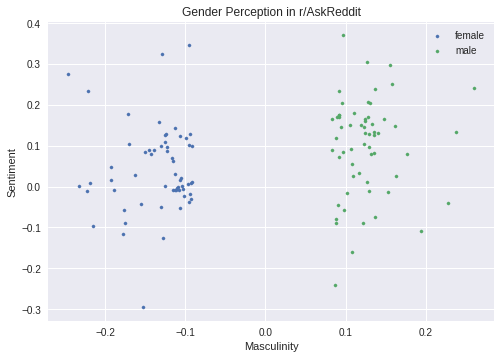

In [21]:
plt.title("Gender Perception in r/AskReddit")
plt.scatter(askreddit_xy['mean_gender'].head(60).values, askreddit_xy['mean_posneg'].head(60).values, s=10, label='female')
plt.scatter(askreddit_xy['mean_gender'].tail(60).values, askreddit_xy['mean_posneg'].tail(60).values, s=10, label='male')
plt.legend()
plt.xlabel("Masculinity")
plt.ylabel("Sentiment")

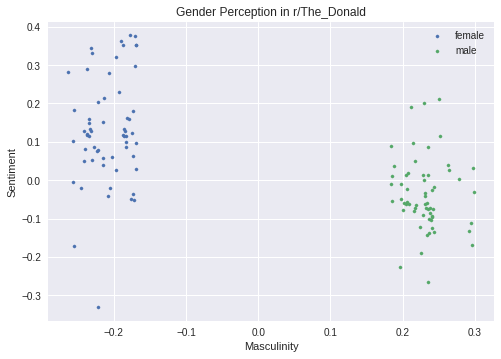

In [22]:
plt.title("Gender Perception in r/The_Donald")
plt.scatter(donald_xy['mean_gender'].head(60).values, donald_xy['mean_posneg'].head(60).values, s=10, label='female')
plt.scatter(donald_xy['mean_gender'].tail(60).values, donald_xy['mean_posneg'].tail(60).values, s=10, label='male')
plt.xlabel("Masculinity")
plt.ylabel("Sentiment")
plt.legend()

A comparision of the plots seems to suggest that gender perception of females relative to the perception of males is more positive in r/The_Donald than in r/AskReddit.

# Comparison of Polarities Across Comments with Different Scores

On reddit, every comment is associated with a score. Comments with high scores are more likely to be displayed and tend to reflect the opinions of the subreddit's users: Users can up- or downvote comments depending if they like them, which in- /decreases the comments score by 1. Comments that many users agree with obtain very high scores, while comments representing opinions that are unpopular among the subreddit's users receive low/negative scores.

Therefore, the score of comments lends itself to an analysis of the kind of comments a subreddit's community approves and disapproves of. We use SocialSent to compare the sentiment values of words when used in comments of different popularity. We analyze the subreddit "politics", and try to determine political bias and to gain insight on the community.

## Methodology 
Our politics corpus contains all 3,845,270 comments that were posted in July, August, and September 2019 on the subreddit "politics". We split our corpus into four roughly equal sized sets: Comments with high negative scores, comments with scores lower than the starting score (which is 1), and comments with scores in range [1, 10), [10, 50), and 50 and above.

We use the twitter seedwords given in the paper and perfom stemming on our corpus to obtain better results. To efficiently calculate the polarity scores, we rewrote the code to generate the dictionaries for all 4 sets in one pass over the data. This enables a ~3x speedup reducing runtime from expected 2h to only 40 min on a laptop. We train word embeddings on every set seperately and use them to generate polarity scores for common words, by performing label propagation for each of the sets.

We normalize the polarity scores of each set by de-meaning. Then, we compare the trends of polarities of interesting words across the different sets and analyze the results.

We plot the histogram of the comment's scores in order to select a balanced partitioning

In [10]:
def score_histogram(subreddit):
    path = os.path.join('data', subreddit, 'outputs.json')
    with open(path) as f:
        total = sum(1 for line in tqdm(f))
    with open(path) as f:
        scores = [json.loads(line)['score'] for line in tqdm(f, total=total)]
    plt.hist(scores, log=True)
    return scores

  1%|          | 29019/3845270 [06:01<13:12:37, 80.25it/s]


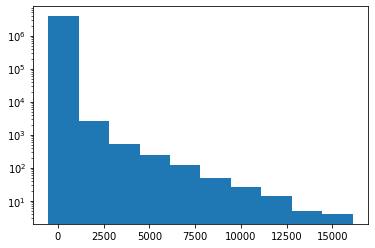

In [11]:
scores = score_histogram('politics')

We decide on intervals for partioning the data and make sure each partition contains roughly the same number of comments

In [18]:
intervals_politics = [(None, -5), (-5, 1), (1, 10), (10, 50), (50, None)]

In [19]:
for low, up in intervals_politics:
    if low is None:
        low = -100000
    if up is None:
        up = 1000000
    print(sum(low <= s < up for s in scores))

112505
418810
2777548
435407
101000


The polarities are computed for each set. This takes around 40 minutes. The code for computing the polarities is available in our github repository. We stem the words to get better results (as mentioned earlier).

In [20]:
for iv in intervals_politics:
    print('Interval: ', iv)
    compute_polarities('politics', iv, intervals_politics, True)

Interval:  (None, -5)
Getting and writing dictionary...


  1%|          | 1025/112505 [00:00<00:10, 10245.93it/s]

Generating word co-occurrences...


100%|██████████| 112505/112505 [00:09<00:00, 11330.80it/s]


Generating PPMI vectors...
Generating SVD vectors...
Factorising 2221026 with shape (2152, 2152)


  0%|          | 0/30 [00:00<?, ?it/s]

Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['correct', 'happi', 'awesom', 'best', 'fantast', 'amaz', 'love', 'nice'] ['sad', 'terribl', 'hate', 'nasti', 'wrong', 'horribl', 'aw', 'worst']


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


Interval:  (-5, 1)
Loading preexisting corpus...


  0%|          | 1128/418810 [00:00<00:37, 11275.66it/s]

Generating word co-occurrences...


100%|██████████| 418810/418810 [00:44<00:00, 9412.32it/s] 


Generating PPMI vectors...
Generating SVD vectors...
Factorising 7084436 with shape (4678, 4678)


  0%|          | 0/30 [00:00<?, ?it/s]

Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['correct', 'happi', 'awesom', 'best', 'fantast', 'amaz', 'love', 'nice'] ['sad', 'terribl', 'hate', 'nasti', 'wrong', 'horribl', 'aw', 'worst']


100%|██████████| 30/30 [02:22<00:00,  4.75s/it]


Interval:  (1, 10)
Loading preexisting corpus...


  0%|          | 1356/2777548 [00:00<03:24, 13554.10it/s]

Generating word co-occurrences...


100%|██████████| 2777548/2777548 [04:40<00:00, 9905.32it/s] 


Generating PPMI vectors...
Generating SVD vectors...
Factorising 25153393 with shape (11331, 11331)


  0%|          | 0/30 [00:00<?, ?it/s]

Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['correct', 'happi', 'awesom', 'best', 'fantast', 'amaz', 'love', 'nice'] ['sad', 'terribl', 'hate', 'nasti', 'wrong', 'horribl', 'aw', 'worst']


100%|██████████| 30/30 [02:50<00:00,  5.69s/it]


Interval:  (10, 50)
Loading preexisting corpus...


  0%|          | 1074/435407 [00:00<00:40, 10739.32it/s]

Generating word co-occurrences...


100%|██████████| 435407/435407 [00:47<00:00, 9205.52it/s] 


Generating PPMI vectors...
Generating SVD vectors...
Factorising 8357990 with shape (5231, 5231)


  0%|          | 0/30 [00:00<?, ?it/s]

Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['correct', 'happi', 'awesom', 'best', 'fantast', 'amaz', 'love', 'nice'] ['sad', 'terribl', 'hate', 'nasti', 'wrong', 'horribl', 'aw', 'worst']


100%|██████████| 30/30 [02:49<00:00,  5.64s/it]


Interval:  (50, None)
Loading preexisting corpus...


  1%|          | 1005/101000 [00:00<00:09, 10039.19it/s]

Generating word co-occurrences...


100%|██████████| 101000/101000 [00:11<00:00, 9179.74it/s]


Generating PPMI vectors...
Generating SVD vectors...
Factorising 2803903 with shape (2526, 2526)


  0%|          | 0/30 [00:00<?, ?it/s]

Create representation...
Get sub embedding...
Bootstrapping...
using seeds ['correct', 'happi', 'awesom', 'best', 'fantast', 'amaz', 'love', 'nice'] ['sad', 'terribl', 'hate', 'nasti', 'wrong', 'horribl', 'aw', 'worst']


100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


We load the data for all partitions, normalize it by subtracting the mean, and join the tables to obtain single dataframe indexed by the word. 

In [255]:
df = load_df('politics', 'stemmed-scores-nolim--5-', scale=True)
df = df.rename(columns={"mean": "mean_0", "std": "std_0", "cooccurring_words": "cooccurring_words_0"}) 

for i, iv in enumerate(intervals_politics[1:]):
    prefix = ('nolim' if iv[0] is None else str(iv[0])) + '-' + ('nolim' if iv[1] is None else str(iv[1])) 
    prefix = 'stemmed-scores-' + prefix + '-'
    
    df_new = load_df('politics', prefix, scale=True)
    df_new = df_new.rename(columns={"mean": "mean_"+str(i+1), "std": "std_"+str(i+1), "cooccurring_words": "cooccurring_words_"+str(i+1)}) 
    df = df.join(df_new, how='inner', rsuffix='', lsuffix='')

In [256]:
len(df)

1997

For each of the 1997 words for which we obtained a polarity score for every partition, the dataframe contains the mean polarity value over all runs, the standard deviation, and the 5 words it co-occurred with most, for every partition.

In [257]:
df.head()

,mean_0,std_0,cooccurring_words_0,mean_1,std_1,cooccurring_words_1,mean_2,std_2,cooccurring_words_2,mean_3,std_3,cooccurring_words_3,mean_4,std_4,cooccurring_words_4
word,,,,,,,,,,,,,,,
perfect,0.358279,0.151657,"[like, fine, think, trump, peopl]",0.111127,0.335076,"[like, trump, exampl, think, peopl]",0.166417,0.211580,"[think, peopl, like, remov, trump]",0.316597,0.216021,"[think, fine, peopl, like, trump]",0.222608,0.185969,"[hes, peopl, like, fine, trump]"
success,0.332649,0.139642,"[remov, countri, democrat, trump, peopl]",0.038485,0.250937,"[think, impeach, like, trump, peopl]",0.257735,0.211368,"[think, remov, like, peopl, trump]",0.237277,0.285932,"[busi, presid, like, peopl, trump]",0.027922,0.148431,"[hes, peopl, like, presid, trump]"
futur,0.310727,0.191233,"[peopl, look, trump, presid, like]",0.180084,0.331138,"[trump, presid, like, think, peopl]",0.223327,0.289862,"[presid, remov, peopl, like, trump]",0.044174,0.268899,"[think, presid, peopl, like, trump]",-0.022084,0.124236,"[generat, like, peopl, presid, trump]"
dick,0.304757,0.165711,"[fuck, peopl, like, trump, suck]",0.008411,0.163275,"[delet, dont, peopl, like, suck]",-0.036323,0.069771,"[cheney, remov, trump, like, suck]",0.007880,0.144758,"[fuck, cheney, like, suck, trump]",0.060287,0.094067,"[right, gt, like, suck, trump]"
daili,0.287656,0.201271,"[delet, like, trump, peopl, basi]",-0.065677,0.145148,"[live, like, trump, peopl, basi]",-0.091719,0.081350,"[like, peopl, caller, trump, basi]",0.020427,0.149485,"[like, peopl, trump, caller, basi]",0.183100,0.167044,"[presid, like, news, trump, basi]"


We plot a histogram of the polarity values for each partition and observe that they are similarly distributed. This suggests that it is reasonable to compare words' polarity values across the different distributions.

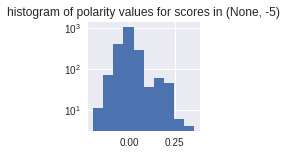

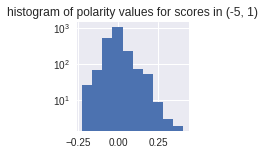

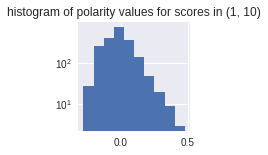

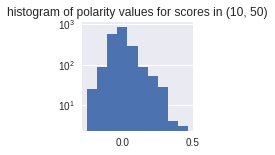

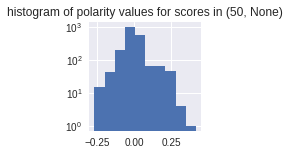

In [258]:
for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.hist(df['mean_'+str(i)], log=True)
    plt.title('histogram of polarity values for scores in ' + str(intervals_politics[i]))
    plt.show()

## Results

To analyze political bias on the politics subreddit, we analyze the polarity values associated with names of both democrat and republican politicians. For each party, we choose two famous representatives: Donald Trump and Mike Pence for the republicans and Elizabeth Warren and Bernie Sanders for the democrats. We plot the polarity scores and their standard deviations over all runs. ($(-\infty, -5), [-5, 1), [1, 10), [10, 50), [50, 100), [100, \infty)$)


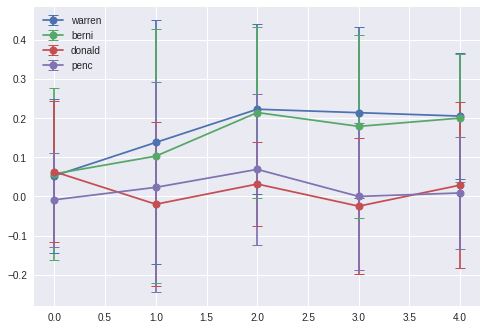

In [265]:
politicians = ['warren', 'berni', 'donald', 'penc']
for p in politicians:
    means = list(df.loc[p][['mean_'+str(i) for i in range(5)]])
    stds = list(df.loc[p][['std_'+str(i) for i in range(5)]])
    plt.errorbar(range(5), means, stds, marker='o', capsize=5, label=p)
plt.legend()

Bernie Sanders and Elizabeth Warren generally have higher polarity scores over all score intervals. This reaffirms the hypothesis that the politics subreddit is politically biased towards the democratic party. The comments with negative upvote scores seem to have lower scores for the democratic politicians, which indicates that comments that talk about the two democrats negatively generally receive lower scores.

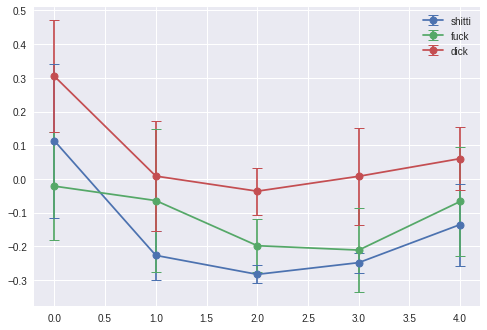

In [266]:
rude = ['shitti', 'fuck', 'dick']
for r in rude:
    means = list(df.loc[r][['mean_'+str(i) for i in range(5)]])
    stds = list(df.loc[r][['std_'+str(i) for i in range(5)]])
    plt.errorbar(range(5), means, stds, marker='o', capsize=5, label=r)
plt.legend()

We can observe that explicit words have high polarity scores in highly downvoted posts. This indicates that the use of explicit words is unpopular on the politics subreddit. However, towards the more upvotes, the more the polarity scores increase again. This leads us to believe that posts that use explicit words tend to voice strong opinions, which tend to be polarising. This would explain why the scores are highest for the posts with the lowest and highest votes.

We also plot the polarity score of religions. Here, we can observe an interesting upwards trend in polarity towards the better rated posts. However, there is a big spike in polarity among the neutrally rated posts.


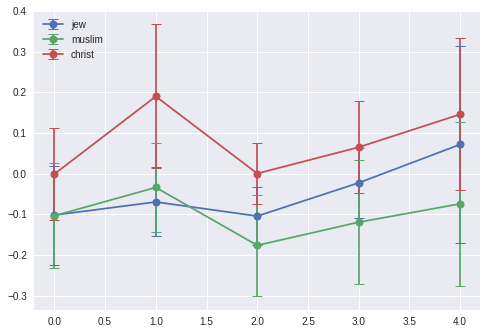

In [267]:
religions = ['jew', 'muslim', 'christ']
for r in religions:
    means = list(df.loc[r][['mean_'+str(i) for i in range(5)]])
    stds = list(df.loc[r][['std_'+str(i) for i in range(5)]])
    plt.errorbar(range(5), means, stds, marker='o', ecolor=None, capsize=5, label=r)
    plt.rcParams.update({'lines.markeredgewidth': 1})
plt.legend()